# CRISPR  Validation
### CompBio coding Challange
**Author:** SarahL.  
**Date:** `July 03, 2024` 

---

## Setup

In [1]:
# Importing necessary libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import pandas as pd
from Bio import Align

# Display a message to confirm successful import
print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Setup Paths
path = os.getcwd()

# Define the input and output paths relative to the current directory
input_path = os.path.join(path, 'src')
output_path = os.path.join(path, 'output')

if not os.path.exists(output_path): os.makedirs(output_path)

## Functions

In [3]:
def getReverseComplement(seq):
    """Takes a DNA sequence string and creates the reverse complement"""
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} # Bases with ambiguous nucleotide N stay N) 
    return "".join(complement.get(base, base) for base in reversed(seq)) 


def readFastq(file_path):
    """Reads FASTQ file and gets seq reverse-complements yields seq"""
    with open(file_path) as fp:
        while True:
            fp.readline() # skip header
            seq = fp.readline().rstrip() # read base sequence
            seq = getReverseComplement(seq) # transform to reverse complement
            fp.readline() # skip placeholder line
            fp.readline() # skip base quality line
            if len(seq) == 0:
                break
            yield seq

            
def getBarcode(seq, barcodes):
    """Identifies barcode sequence from given dict within the first 20 nt and trimm the sequence"""
    pattern = r'|'.join(re.escape(barcode) for barcode in barcodes.values())
    match = re.search(pattern, seq[1:20]) # search first 20 nt to account for frameshift of few nt
    if match:
        trimmed_seq = seq[match.end()+1:-15] #trimm off barcode and adapter and 15 nt from end (both sides have barcode and adapter)
        barcode = seq[match.start()+1:match.end()+1] #get barcode of sequence
        return trimmed_seq, barcode #return trimmed sequence and matched barcode
    else:
        return None, None
    

def findTarget(aligned_ref, aligned_seq, pattern, ntIndex):
    """Find target pattern in reference alignement and output target nucleotide and PAM from aligned seq"""
    match = re.search(pattern, aligned_ref) # Find target in reference alignement and get index
    if match:
        target = aligned_seq[match.start()+ntIndex-1] # Get the target base of aligned target seq
        PAM = aligned_seq[match.end():match.end()+4] # Get the PAM sequence of 4nt at the end of the pattern
        if 'N' in PAM or '-' in PAM: # If there is gap or N nt in the PAM sequence
            return None, None
        return target,PAM
    else:
        return None, None #Insertions in target seq

    
def alignSeq(sequence, reference, target_pattern, ntIndex):    
    """Aligns the sequence from fastq file with Needleman-Wunsch to reference and returns sequences of best alignement"""
    #Initalise Aligner and parameters
    aligner = Align.PairwiseAligner()
    aligner.match_score = 1.0
    aligner.mismatch_score = -1.0
    aligner.gap_score = -3
    aligner.wildcard = "N"

    alignments = aligner.align(reference, sequence)# Align sequence and reference
    if alignments.score < 10: # If alignement bad due to bad sequencing and sample prep errors
        return None,None 
    
    best_alignment = max(alignments, key=lambda aln: aln.score)# Get highest scoring alignement
    
    aligned_ref, aligned_seq = best_alignment
    target,PAM = findTarget(aligned_ref,aligned_seq,target_pattern,ntIndex)#Get PAM and Targetnt
    return target,PAM 
    
    

def initializeMatrices():
    """Seperates list of sequences into dict according to dict of barcodes of replicas"""
    letters = ['A', 'C', 'G', 'T']
    combinations = [a + b for a in letters for b in letters]
    matrix = pd.DataFrame(0, index=combinations, columns=combinations)
    return matrix


def createHeatmap(matrices_freq, output_path):
    """Create the heatmaps from dict of frequency matrices and saves them"""
    for key, matrix in matrices_freq.items():
        # Create plot
        sns.heatmap(matrices_freq[key], cmap='YlGnBu', annot=True, annot_kws={"fontsize":8},fmt='.1g')

        plt.title(f"PAM Profiling Heatmap for {key}")
        plt.xlabel('PAM positions 3-4')
        plt.ylabel('PAM positions 1-2')
        
        # Save plot
        plt.savefig(os.path.join(output_path, f"heatmap_{key}.png"))# Save plot as png
        plt.show()# Display the plot when calling function




def getFreqMat(barcodes, file_path, target_pattern, reference, ntIndex):
    """
    Create and calculate frequency matrices from sequences
        Outputs:
            -matrices_freq : dict with keys as replicates storing their frequency matrix 
            -unmatched_barcode : all sequences where the barcode could not be identified
            -unmatched_target : all sequences where the target region or PAM could not be identified
            -total_seq : counter with total number of sequences
    """
    # Initialize count matrix dict
    matrices_count = {key: initializeMatrices() for key in barcodes}
    matrices_conversion = {key: initializeMatrices() for key in barcodes}
    
    total_seq = 0 # Get total number of sequences
    unmatched_barcode = [] # List to store barcode unmatched sequences
    unmatched_target = [] # List to store target unmatched sequences and bad quality alignement
    
    #Create count matrices
    for sequence in readFastq(file_path): 
        total_seq += 1
        trimmed_sequence,bc = getBarcode(sequence,barcodes) # get barcode and trimmed sequence
        if bc == None:
            unmatched_barcode.append(sequence)
            continue
        else: 
            key= next((k for k, v in barcodes.items() if v == bc), None) # Get correspondiing replicate to barcode
            target, PAM = alignSeq(trimmed_sequence,reference,target_pattern,ntIndex) # Get target nt and PAM by alignement
            if target== None: # Check if target was found and is valid
                unmatched_target.append(trimmed_sequence)
                continue
            matrices_count[key].loc[PAM[:2], PAM[2:]] += 1 # Total count matrix
            if target =='G': 
                matrices_conversion[key].loc[PAM[:2], PAM[2:]] += 1 #Count matrix G occurence
                continue
                
    # Create frequency matrix from counts
    matrices_freq = {key: initializeMatrices() for key in barcodes}
    for key in barcodes.keys():
        matrices_freq[key] = matrices_conversion[key] / matrices_count[key]
        
    return matrices_freq,unmatched_barcode,unmatched_target,total_seq



## Analysis

### Specify parameters

In [4]:
# Specify barcodes 
barcodes = {"rep1": "GTCAGT","rep2": "TAGCCT","rep3": "CGGTAC"}

# Specify target sequence / binding site of CRISPR 
target_pattern = "CATACCTATGGTTTCATCCG"

# Index of target nucleotide within target sequence
ntIndex= 8

# Specify reference amplicon sequence without barcodes and sequencing primers for alignement -> PAM is put as NNNN
reference ='TATCATGTCTGCTCGAAGCGGCCGTACCTCTAGAGCCATTTGTCTCGCTGAAGTACAAGTGGTAGACTAGNNNNNCAGCATACCTATGGTTTCATCCGNNNNGGCCGCTTGTGGATGAATACTGCCATTTGTCTCAAGATCTAGTTACGCCAAGCTTAAAAAAGCACCGACTCGGTGCCACTTTTTCAAGTTGATAACGGACTAGCCTTATTTCAACTTGCTATGCTGTTTCCAGCATAGCTCTGAAACC'

# Specify path to input file 
file_path =os.path.join(input_path, 'library.fastq')


### Run Code

In [5]:
# Generate frequency matrices
matrices_freq,unmatched_barcode,unmatched_target,total_seq = getFreqMat( barcodes, file_path, target_pattern,reference,ntIndex)

### Generate Plots

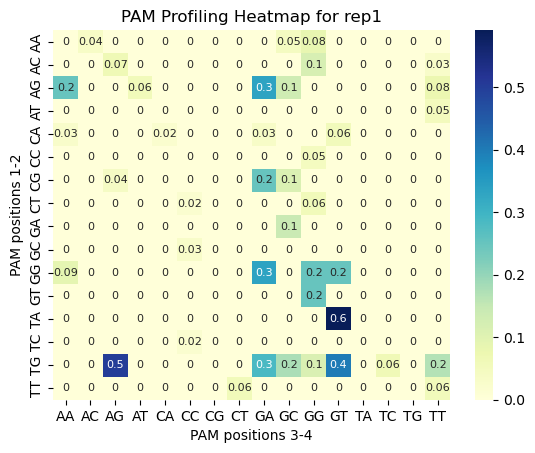

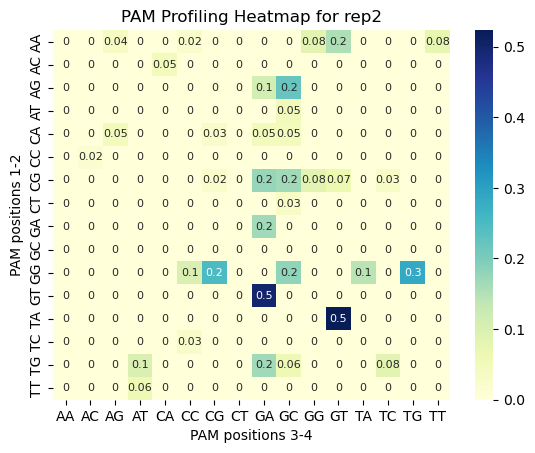

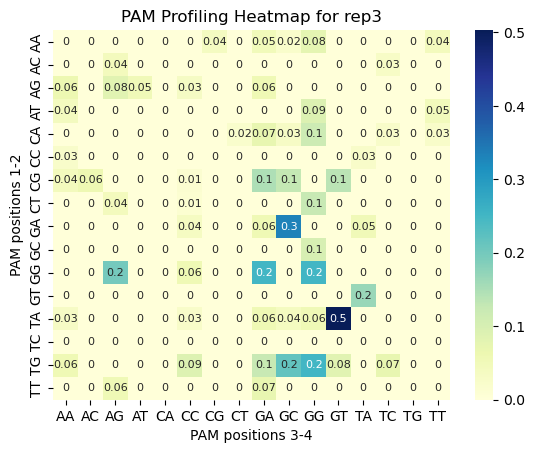

In [6]:
# Create, show and save heatmaps
createHeatmap(matrices_freq, output_path)

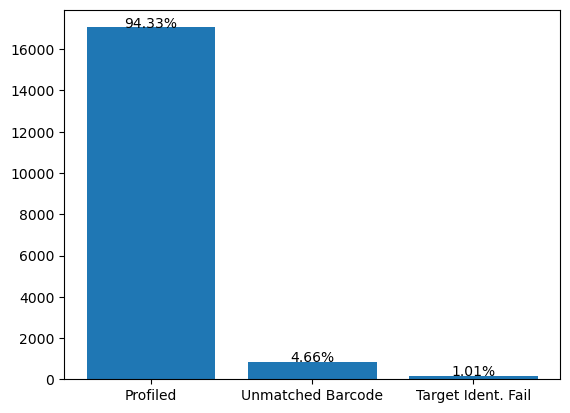

In [7]:
# Barchart showcasing distribution of unaccounted reads

counts=[total_seq-len(unmatched_target)-len(unmatched_barcode),len(unmatched_barcode),len(unmatched_target)]
percentage = [round(i/sum(counts)*100, 2) for i in counts]
labels= ['Profiled','Unmatched Barcode','Target Ident. Fail']

plt.bar(labels, counts) 
for i in range(0,len(counts)):plt.text(i,counts[i], f"{percentage[i]:.2f}%", color='black', ha="center")


In [8]:
print(counts)

[17065, 843, 182]
